In [ ]:
import tensorflow as tf
import os

In [ ]:
# its just to avoid out of memory issues for gpu memory.
gpus =  tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)


In [ ]:
import cv2
import imghdr #Determine the type of an image
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/data"
img_exts = ["jpg", "png", "bmp","jpeg"]


### how read a image

(1440, 1920, 3)


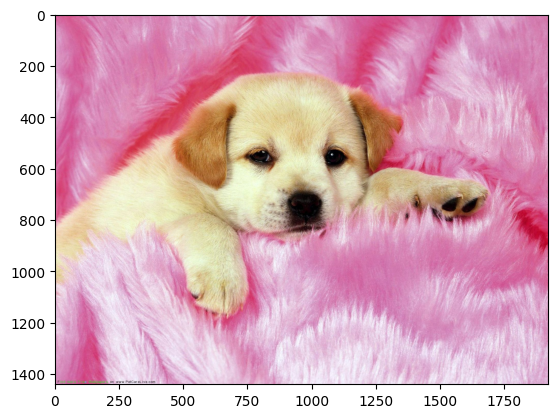

In [ ]:
image = cv2.imread(os.path.join(data_dir,"Happy","327879.jpg")) #reading image
print(image.shape)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB)) #to convert BGR colour to RGB (cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.show()

#### removing the images which are not in proper extension format.

In [ ]:
for image_class in os.listdir(data_dir):
    #print(image_class)
    for image in os.listdir(os.path.join(data_dir,image_class)):
        #print(image)
        image_path = os.path.join(data_dir,image_class,image)
        #print(image_path)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path) # this will give the extension of the image.
            if tip not in img_exts:
                print(f"{image_path} extension is not in img_exts")
                os.remove(image_path)
        except Exception as e:
            print(f"issue with {image_path}")


##  1.2 Load data

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(data_dir) # thiS will create a data-generator

Found 138 files belonging to 2 classes.


In [ ]:
data_generator = data.as_numpy_iterator() # this will create a iterator to access the data

In [ ]:
Batch = data_generator.next() # finally accessing the data.
len(Batch) # it is 2 as our images and labels.

2

In [ ]:
# Batch[0] numpy array  representaion of images as follows:
Batch[0]
len(Batch[0]) #this will represent first batch of images which is contaning 32 images according to the batch size.

32

In [ ]:
# Batch[1] numpy  array representation of labels as follows:
Batch[1]
len(Batch[1])

32

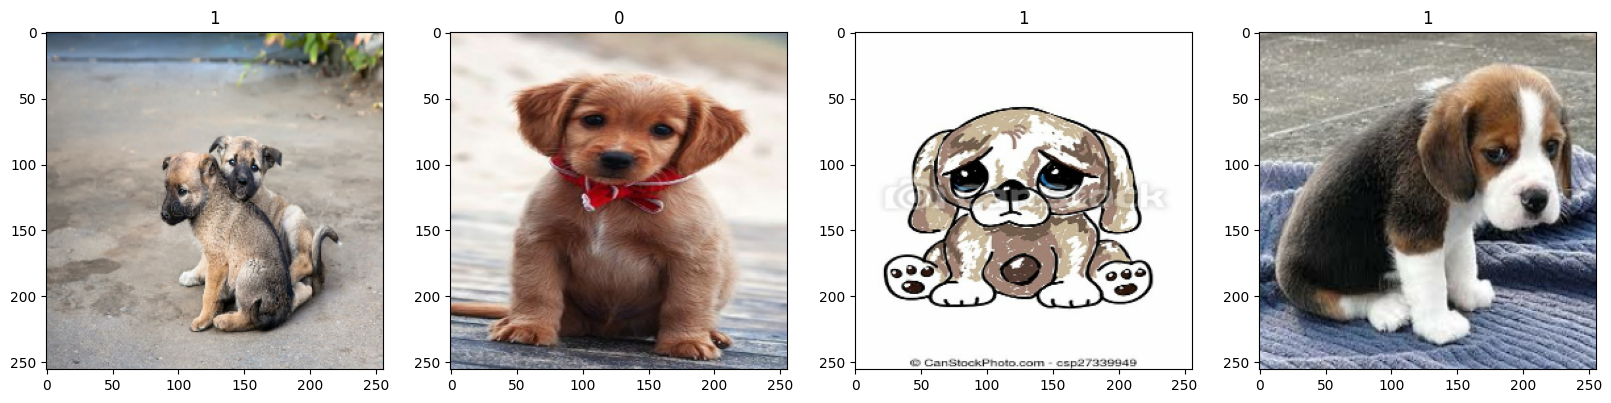

In [ ]:
fig,ax = plt.subplots(ncols=4,figsize=(20,10))
for idx,img in enumerate(Batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(Batch[1][idx])


## 2.0 Preprocessing data

### 2.1 scaling data

##### why to scale data,in section 1.2 while loading data we are using keras utils functionility in which keras will convert our data into numpy data using data pipeline,our image data will always have a range of 0 to 255 pixels,while feeding this data to network its a good practice to scale down the data in-between 0 and 1, as a network uses gradient descent to learn about data.
##### lets check how to scale image data between 0 and 1 for one record.

In [ ]:
scaled_data = Batch[0]/255

In [ ]:
scaled_data.min(),scaled_data.max()

(0.0, 1.0)

#### but we know batch[0] represent only one batch of 32 images,but we need to scale all of the images as follows:

In [ ]:
data = data.map(lambda x,y : (x/255,y))

In [ ]:
# now lets chcek what is min and max value which is scaled for one batch.
data.as_numpy_iterator().next()[0].max(),data.as_numpy_iterator().next()[0].min()

(1.0, 0.0)

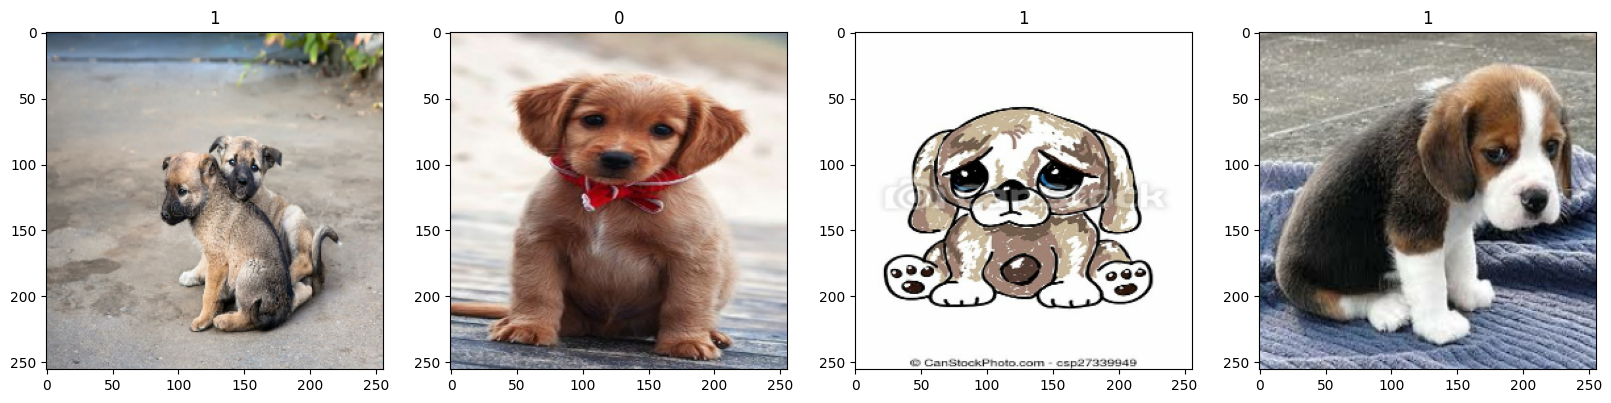

In [ ]:
fig,ax = plt.subplots(ncols=4,figsize=(20,10))
for idx,img in enumerate(Batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(Batch[1][idx])


## 2.2 Split Data

In [ ]:
len(data)


5

In [ ]:
train_size = int(len(data)*.7)
val_size  = int(len(data)*.1)+1
test_size  = int(len(data)*.1)+1

In [ ]:
train_size+ val_size + test_size

5

In [ ]:
training_data = data.take(train_size)
validation_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size+val_size).take(test_size)

->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->*->

## 3.0 Model Building

##### 3.1 Build a deep model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D,Dense,Conv2D,Flatten

In [ ]:
model = Sequential()
model.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1,activation="sigmoid"))


In [ ]:
model.compile(optimizer = "adam",loss=tf.losses.BinaryCrossentropy(),metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [ ]:
logs = 'logs_dir'
callbacks = tf.keras.callbacks.TensorBoard(log_dir=logs) #variable logs is assigned the value 'logs_dir', indicating the directory path where TensorBoard logs will be stored. The callbacks object is then set up with a TensorBoard callback, allowing the model's training progress to be visualized in TensorBoard using the specified log directory.

In [ ]:
hist = model.fit(training_data,epochs=50,validation_data=validation_data,callbacks=[callbacks])

Epoch 1/50
3/3 [==============================] - 5s 1s/step - loss: 0.1543 - accuracy: 0.9792 - val_loss: 0.1364 - val_accuracy: 1.0000
Epoch 2/50
3/3 [==============================] - 2s 657ms/step - loss: 0.1324 - accuracy: 0.9688 - val_loss: 0.0973 - val_accuracy: 0.9688
Epoch 3/50
3/3 [==============================] - 3s 673ms/step - loss: 0.1049 - accuracy: 0.9896 - val_loss: 0.0588 - val_accuracy: 1.0000
Epoch 4/50
3/3 [==============================] - 3s 690ms/step - loss: 0.0983 - accuracy: 0.9688 - val_loss: 0.0800 - val_accuracy: 0.9688
Epoch 5/50
3/3 [==============================] - 4s 1s/step - loss: 0.0682 - accuracy: 0.9896 - val_loss: 0.0509 - val_accuracy: 1.0000
Epoch 6/50
3/3 [==============================] - 3s 689ms/step - loss: 0.0374 - accuracy: 1.0000 - val_loss: 0.0290 - val_accuracy: 1.0000
Epoch 7/50
3/3 [==============================] - 2s 634ms/step - loss: 0.0329 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 1.0000
Epoch 8/50
3/3 [==========

In [ ]:
hist.history

{'loss': [0.15433968603610992,
  0.1324295699596405,
  0.10491031408309937,
  0.09829020500183105,
  0.06824859231710434,
  0.0374414436519146,
  0.03286482393741608,
  0.02194427140057087,
  0.018241791054606438,
  0.006405867636203766,
  0.0069502959959208965,
  0.004098799079656601,
  0.0032104812562465668,
  0.002526473253965378,
  0.004191780928522348,
  0.0025349122006446123,
  0.0012482759775593877,
  0.0017658487195149064,
  0.0006419147830456495,
  0.0009985911892727017,
  0.0006829805788584054,
  0.0006290723104029894,
  0.0006840315763838589,
  0.00045833844342269003,
  0.00036138587165623903,
  0.00035198728437535465,
  0.0003325349243823439,
  0.00018665588868316263,
  0.00016867631347849965,
  0.0002684841747395694,
  0.00021321112581063062,
  0.00020593339286278933,
  0.00017897975340019912,
  0.00017586990725249052,
  0.00018750347953755409,
  0.0001871713757282123,
  0.00012873760715592653,
  0.00015780173998791724,
  0.0001531537127448246,
  0.00015290535520762205,
  

### 3.2 plotting performanse

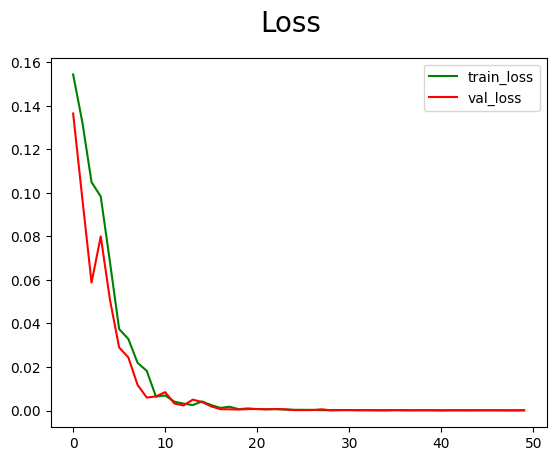

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'],color = 'green',label='train_loss')
plt.plot(hist.history['val_loss'],color ='red',label='val_loss')
fig.suptitle("Loss",fontsize=20)
plt.legend(loc = 'upper right')
plt.show()


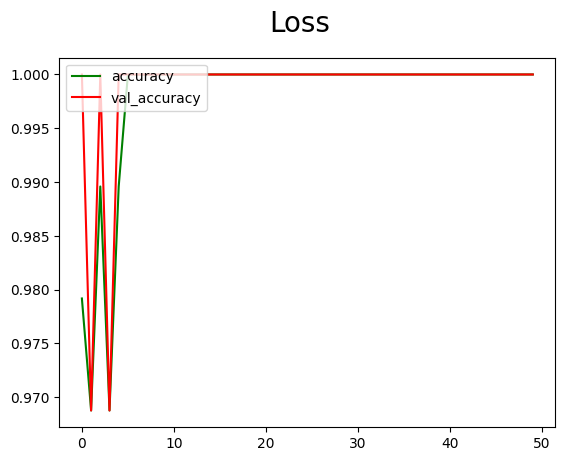

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'],color = 'green',label='accuracy')
plt.plot(hist.history['val_accuracy'],color ='red',label='val_accuracy')
fig.suptitle("Loss",fontsize=20)
plt.legend(loc = 'upper left')
plt.show()

# 4.0 Evaluating Performance

### 4.1 metrics

In [ ]:
from tensorflow.keras.metrics import Recall,Precision,BinaryAccuracy

In [ ]:
recall = Recall()
precision = Precision()
accuracy = BinaryAccuracy()

In [ ]:
len(test_data)

1

In [ ]:
for batch in test_data.as_numpy_iterator():
  x,y = batch
  yhat = model.predict(x)
  recall.update_state(y,yhat)
  precision.update_state(y,yhat)
  accuracy.update_state(y,yhat)

1/1 [==============================] - 1s 703ms/step


In [ ]:
print(f"precision is {precision.result().numpy()},recall is {recall.result().numpy()},accuracy is {accuracy.result().numpy()}")

precision is 1.0,recall is 1.0,accuracy is 1.0


In [ ]:
model.save(os.path.join('model','model.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 4.2 Prediction

In [ ]:
#resized_image = tf.image.resize(image,(256,256))
#plt.imshow(resized_image.numpy().astype(int))
#plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

In [ ]:
def sentiment_prediction(image):
    new_model = load_model("/content/model/model.h5")
    image = cv2.imread(image)
    resized_image = tf.image.resize(image,(256,256))
    yhat = new_model.predict(np.expand_dims(resized_image/255,0))
    if yhat < 0.5:
        print("puppy is feeling happy")
    else:
        print("puppy is in sad mood")



In [ ]:
sentiment_prediction("/content/1140-pet-anxiety-sad-dog.jpg")

1/1 [==============================] - 0s 117ms/step
puppy is in sad mood
